In [21]:
## Notebook to develop toy model of dynamics to be used as input simulator to a constrained generative model. 
## Dynamics are given by a ball that is subject to gravity and moves around in 2d. 

In [12]:
## List of imports (keep it simple)
import numpy as np
import scipy 
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import subprocess

In [13]:
## List of parameters
dim = 2 #dimensionality of the problem
g = 0 #m/(s^2) (gravitational constant)
d = 20 # size of a square enclosure
t = 40 # time to simulate for
dt = 100000
w = 20
h = 20
dpi = 4

env_params = {'dimension':dim,
              'grav_constant':g,
              'enclosure_size':d,
              'simtime':t,
              'timesteps':dt,
              'dpi':dpi}


A = np.zeros((4,4))
A[2,0] = 1
A[3,1] = 1 ## dynamics matrix
e = 1 ## reduction in force 

dyn_params = {'grav_constant':g,'dyn_matrix':A,'elasticity':e}

m = 10.0 # mass of ball
r = 10*env_params['enclosure_size'] # radius of ball

ball_params = {'mass':m,'radius':r}




In [14]:
## In order to set up numerical integration, we need a callable function that calculates derivatives of the movement
## as a set of first order differential equations. Thus we define the following

## Define a form on forces as an external effect (we need a form that will return a value for non-integer evaluated 
## points in t):

def ball(y,t,env_params,dyn_params,ball_params,F):
    
    # Define Effect of forces
    # We have the forces determined as Fx and Fy, a sequence that the input gets to see
    # Determine effect of forces:
    F_vec = np.zeros((4))
    F_vec[3] -= dyn_params['grav_constant']*ball_params['mass'] ## Effect of gravity
    F_vec[2:4] += F(t) ## Deterministic exterior force being applied
    
    ## We want elasticity: 
    if np.any(abs(y[0:2])>env_params['enclosure_size']):
        F_imp = dyn_params['elasticity']*(abs(y[0:2])>env_params['enclosure_size'])*100000 ## Bounce back
        F_elast = F_imp*-np.sign(y[0:2])
  
    else:
        F_elast = np.zeros((2))
    F_vec[2:4] += F_elast
    
    ## F = ma
    a_vec = F_vec/ball_params['mass']
    
    ## Write down the full dynamics equation:
    ydot = np.dot(y,dyn_params['dyn_matrix'])+a_vec

    return ydot



In [15]:
## Solve for given F,y0,t
# F = lambda t: np.array([10*np.sin(t),200*np.cos(t)])
# F = lambda t: np.array([np.sin(3*t),np.cos(3*t)])
F = lambda t: np.array([0,0])
y0 = np.zeros((4))
# y0[2]-= (1./3)/10
# y0[0]-=20
t = np.linspace(0,env_params['simtime'],env_params['timesteps'])
sol = odeint(ball, y0, t, args=(env_params,dyn_params,ball_params,F))

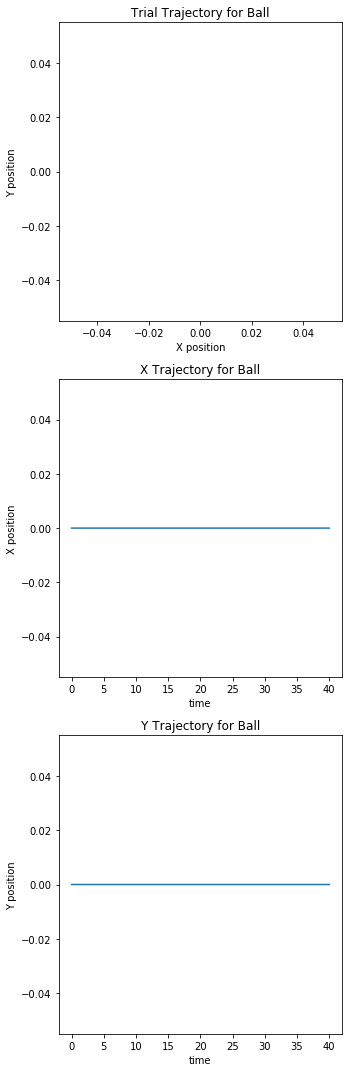

In [16]:
fig,ax = plt.subplots(3,1,figsize = (5,15))
ax[0].plot(sol[:,0],sol[:,1])
ax[0].set_title('Trial Trajectory for Ball')
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[1].plot(t,sol[:,0])
ax[1].set_title('X Trajectory for Ball')
ax[1].set_xlabel('time')
ax[1].set_ylabel('X position')
ax[2].plot(t,sol[:,1])
ax[2].set_title('Y Trajectory for Ball')
ax[2].set_xlabel('time')
ax[2].set_ylabel('Y position')
plt.tight_layout()
plt.show()

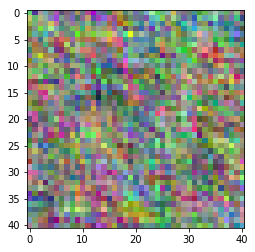

In [32]:
# Render a background (static for now)
# background = np.concatenate([np.ones((2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,1))*i for i in [0.5,0.7,0.1]],axis = -1)
background = (np.random.rand(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3))

## We design a covariance matrix that is spatially correlated gaussian noise: 
# We choose a squared exponential kernel: 
length_covar = (2*env_params['enclosure_size']+1)**2
index = np.arange(length_covar)
## Make a meshgrid to evaluate:
xx,yy = np.meshgrid(index,index)

diff = abs(xx-yy)
gamma = 6
distances = np.exp(-(np.floor(diff/(2*env_params['enclosure_size']+1))**2+np.mod(diff,(2*env_params['enclosure_size'])+1)**2)/gamma)
mat = distances+np.eye(length_covar)*2
## Now sample uniform noise:
array = np.zeros((length_covar,3))
for i in range(3):
    noise = np.random.multivariate_normal(np.zeros((length_covar,))+0.5,mat)
    noise = (noise-np.min(noise))/np.max(noise-np.min(noise))
    array[:,i] = noise
# corr_noise = np.dot(chol,noise).reshape(env_params['width'],env_params['height'],3)
# corr_noise_min = [np.min(corr_noise[:,:,i]) for i in range(1)]
# corr_noise = corr_noise-corr_noise_min
# corr_noise_max = [np.max(corr_noise[:,:,i]) for i in range(1)]

# corr_noise = corr_noise/corr_noise_max

# plt.imshow(corr_noise[:,:,0])
plt.imshow(array.reshape(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3))
background = array.reshape(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3)

In [17]:
# Generate frames for a video:
all_datadirect = 'datadirectory'
try:
    os.mkdir(all_datadirect)
except:
    print('all data directory already exists!')

videodirectory = 'toydynamics_nograv'
try:
    os.mkdir(all_datadirect+'/'+videodirectory)
except:
    print('Directory already exists!')

# Sample at the seconds timescale:
frames = np.linspace(0,env_params['timesteps']-1,30*env_params['simtime']).astype('int')
print('Generating Frames')

# Preprocess 
sol[sol>(env_params['enclosure_size']-0.5)]=env_params['enclosure_size']-0.5
sol[sol<(-env_params['enclosure_size']+0.5)]=-env_params['enclosure_size']+0.5
# sol[sol<-31.5]=-31.5

period = 2*np.pi*1./47.431
background = (np.random.rand(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3))


for i,ti in enumerate(frames):
    fig = plt.figure(frameon = False)
    fig.set_size_inches(w,h)
    ax = plt.Axes(fig,[0.,0.,1.,1.,])
    ax.set_axis_off()
    fig.add_axes(ax)
#     bnoise = np.random.randn(41,41,3)/10
#     background = (np.random.rand(2*env_params['enclosure_size']+1,2*env_params['enclosure_size']+1,3))
    ax.imshow(np.clip(background,0,1))
    ax.plot(sol[ti,0]+env_params['enclosure_size'],-sol[ti,1]+env_params['enclosure_size'],
            'o',
            color = (0.5*(np.cos(period*i)+1),0.5*(np.cos(period*i)+1),0.5*(np.cos(period*i)+1)),
            markersize=ball_params['radius'])
    ax.axis('off')
    plt.savefig(all_datadirect+'/'+videodirectory+'/'+'frame%03d.png'%i,
                bbox_inches='tight',
                pad_inches=0,
                dpi = dpi)
    plt.close()
os.chdir(all_datadirect+'/'+videodirectory)
print("Generating video")
subprocess.call(['ffmpeg', '-framerate', str(30), '-i', 'frame%03d.png', '-r', '30','Video_ball_color_small'+'.mp4'])
os.chdir('../../')


all data directory already exists!
Directory already exists!
Generating Frames
Generating video


In [23]:
np.sqrt(5043)

71.014083110323966